In [2]:
import torch
torch.set_grad_enabled(False)  # Disable gradient calculation for inference

In [3]:
import sys

sys.path.append('/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_segfm-robin/repos/segfm3d-nora')
sys.path.append('/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_segfm-robin/repos/nnunetv2')

In [5]:
config = {
    "DATA_DIR": "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data",
    "RESULTS_DIR": "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/results",
    "SAM_CKPT_PATH": "/nfs/norasys/notebooks/camaret/SAM-Med3D/ckpt/sam_med3d_turbo_bbox_cvpr.pth",
    "SAM_REPO_DIR": "/nfs/norasys/notebooks/camaret/SAM-Med3D",
    "ONNX_MODEL_PATH": "/nfs/norasys/notebooks/camaret/model_inference/models/sammed3d.onnx",
    "NNINT_CKPT_DIR": "/nfs/norasys/notebooks/camaret/model_checkpoints/nnint",
}

In [6]:
%load_ext autoreload
%autoreload 1

In [7]:
import os
import torch
from nnInteractive.inference.inference_session import nnInteractiveInferenceSession
import os.path


nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [8]:
args_for_network = {
    "arch_class_name": "dynamic_network_architectures.architectures.unet.ResidualEncoderUNet",
    "arch_kwargs": {
        "n_stages": 6,
        "features_per_stage": [32, 64, 128, 256, 320, 320],
        "conv_op": "torch.nn.modules.conv.Conv3d",
        "kernel_sizes": [
            [3, 3, 3],
            [3, 3, 3],
            [3, 3, 3],
            [3, 3, 3],
            [3, 3, 3],
            [3, 3, 3],
        ],
        "strides": [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]],
        "n_blocks_per_stage": [1, 3, 4, 6, 6, 6],
        "n_conv_per_stage_decoder": [1, 1, 1, 1, 1],
        "conv_bias": True,
        "norm_op": "torch.nn.modules.instancenorm.InstanceNorm3d",
        "norm_op_kwargs": {"eps": 1e-05, "affine": True},
        "dropout_op": None,
        "dropout_op_kwargs": None,
        "nonlin": "torch.nn.LeakyReLU",
        "nonlin_kwargs": {"inplace": True},
    },
    "arch_kwargs_req_import": ["conv_op", "norm_op", "dropout_op", "nonlin"],
    "input_channels": 8,
    "output_channels": 2,
    "allow_init": True,
    "deep_supervision": True,
}

In [12]:
from nnunetv2.utilities.get_network_from_plans import get_network_from_plans
network = get_network_from_plans(**args_for_network).cuda()
orig_checkpoint_dir = '/nfs/norasys/notebooks/camaret/model_checkpoints/nnint/nnInteractive_v1.0/'
newer_checkpoint_dir = "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_segfm-robin/data/model-checkpoints/try_from_nb_less_augment/"
if os.path.exists(newer_checkpoint_dir):
    chkpt_dict = torch.load(os.path.join(newer_checkpoint_dir, 'fold_0/checkpoint_final.pth'), weights_only=False)
else:
    chkpt_dict = torch.load(os.path.join(orig_checkpoint_dir, 'fold_0/checkpoint_final.pth'), weights_only=False)

network.load_state_dict(chkpt_dict['network_weights'])

<All keys matched successfully>

In [13]:
%aimport src.training.transforms

In [14]:
from batchgeneratorsv2.transforms.spatial.mirroring import MirrorTransform
from batchgeneratorsv2.transforms.spatial.spatial import SpatialTransform
from batchgeneratorsv2.transforms.utils.compose import ComposeTransforms
from batchgeneratorsv2.transforms.utils.deep_supervision_downsampling import (
    DownsampleSegForDSTransform,
)
from batchgeneratorsv2.transforms.utils.random import RandomTransform
from batchgeneratorsv2.transforms.utils.remove_label import RemoveLabelTansform

from src.training.transforms import AddSegToImageTransform
from src.training.transforms import NormalizeSingleImageTransform
from src.training.transforms import AddBBoxAndEmptyChannelsSingleClassTransform
from src.training.transforms import MONAIRandSpatialTransform
from src.training.transforms import MONAIFixedSpatialTransform


only_2d_bbox = False

test_transform = ComposeTransforms(
    [
        NormalizeSingleImageTransform(),
        MONAIFixedSpatialTransform(),
        RemoveLabelTansform(segmentation_channels=None, label_value=-1, set_to=0),
        AddBBoxAndEmptyChannelsSingleClassTransform(only_2d_bbox=only_2d_bbox),
        AddSegToImageTransform(),
    ]
)

# let's make very little augmentation
train_transform = ComposeTransforms(
    [
        NormalizeSingleImageTransform(),
        # MONAIRandSpatialTransform(
        #     rotate_range=(0.025 * np.pi * 2, 0.025 * np.pi * 2, 0.025 * np.pi * 2),
        #     scale_range=(0.2, 0.2, 0.2),
        #     prob_affine=0.5,
        # ),
        MONAIFixedSpatialTransform(),
        # RandomTransform(
        #     apply_probability=0.1,
        #     transform=GaussianNoiseTransform(
        #         noise_variance=(0, 0.1), p_per_channel=1, synchronize_channels=True
        #     ),
        # ),
        # RandomTransform(
        #     apply_probability=0.2,
        #     transform=GaussianBlurTransform(
        #         blur_sigma=(0.5, 1.0),
        #         benchmark=True,
        #         synchronize_channels=False,
        #         synchronize_axes=False,
        #         p_per_channel=0.5,
        #     ),
        # ),
        # MirrorTransform(allowed_axes=(0, 1, 2)),
        RemoveLabelTansform(segmentation_channels=None, label_value=-1, set_to=0),
        DownsampleSegForDSTransform(
            ds_scales=[
                [1.0, 1.0, 1.0],
                [0.5, 0.5, 0.5],
                [0.25, 0.25, 0.25],
                [0.125, 0.125, 0.125],
                [0.0625, 0.0625, 0.0625],
            ]
        ),
        AddBBoxAndEmptyChannelsSingleClassTransform(only_2d_bbox=only_2d_bbox),
        AddSegToImageTransform(),
    ]
)

Initializing AddBBoxAndEmptyChannelsSingleClassTransform
Initializing AddSegToImageTransform
Initializing AddBBoxAndEmptyChannelsSingleClassTransform
Initializing AddSegToImageTransform


In [15]:
from src.training.npzdataset import NPZPytorchDataset, NPZDataset
from src.training.utils import fast_ids_to_deterministic_floats
import numpy as np

from glob import glob
parent_folder = '/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data/3D_train_npz_random_10percent_16G/'
parent_save_folder = '/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/SegFM3D/data/own-preproc/'

all_npz_file_paths = glob(os.path.join(parent_folder, '**/*.npz'), recursive=True)
to_exclude = ['Ultrasound/US_Low-limb-Leg/US_Low-limb-Leg07.npz',
       'Ultrasound/US_Low-limb-Leg/US_Low-limb-Leg24.npz',
       'Ultrasound/US_Low-limb-Leg/US_Low-limb-Leg37.npz',
       'CT/CT_Abdomen1K/CT_Abdomen1K_Case_00931.npz',
       'Microscopy/Microscopy_cremi/Microscopy_cremi_002_sc.npz',
       'Microscopy/Microscopy_cremi/Microscopy_cremi_000_sc.npz',
       'Microscopy/Microscopy_cremi/Microscopy_cremi_001_sc.npz']


identifiers = np.array([f.replace(parent_folder, "") for f in all_npz_file_paths])
identifiers = np.array([f for f in identifiers if f not in to_exclude])

train_mask = fast_ids_to_deterministic_floats(identifiers) < 0.8
train_files = identifiers[train_mask]
test_files = identifiers[~train_mask]
dataset_tr = NPZDataset(parent_folder, parent_save_folder, train_files)
dataset_val = NPZDataset(parent_folder, parent_save_folder, test_files)
train_set = NPZPytorchDataset(
    dataset_tr, transform=train_transform)

test_set = NPZPytorchDataset(
    dataset_val, transform=test_transform)

In [16]:
n_jobs = int(os.environ['SLURM_CPUS_PER_TASK'])

In [17]:
import torch
train_loader = torch.utils.data.DataLoader(
    train_set,
    shuffle=True,
    drop_last=True,
    num_workers=n_jobs,
    batch_size=2,
)

In [18]:
test_set = NPZPytorchDataset(
    dataset_val, transform=test_transform)
test_loader = torch.utils.data.DataLoader(
    test_set,
    shuffle=False,
    drop_last=False,
    num_workers=n_jobs,
    batch_size=2,
)

In [19]:
from tqdm.autonotebook import tqdm, trange
import torch
from src.training.model_wrap import ModelPrevSegAndClickWrapper
from src.training.utils import defer_keysignal_with_grad

wrapped_network = ModelPrevSegAndClickWrapper(network, n_max_clicks=1)

optim_network = torch.optim.AdamW(
    wrapped_network.parameters(), lr=3e-4, weight_decay=1e-5
)

with custom forward print shape


In [20]:
from copy import deepcopy
import shutil
out_dir = '/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_segfm-robin/data/model-checkpoints/try_from_nb_no_augment/'#'/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_segfm-robin/data/model-checkpoints/try_from_nb_all_data_competition_bbox/'
try:
    shutil.copytree(orig_checkpoint_dir, out_dir)
except FileExistsError:
    print(f"path {out_dir} exists already, fine")
trained_chkpt_path = os.path.join(out_dir, 'fold_0/checkpoint_final.pth')
assert os.path.exists(trained_chkpt_path)


trained_chkpt = deepcopy(chkpt_dict)

path /nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_segfm-robin/data/model-checkpoints/try_from_nb_no_augment/ exists already, fine


In [ ]:
accumulate_batch_size = 16
n_batches_accumulate = accumulate_batch_size // 2

In [22]:
from src.training.utils import compute_binary_dsc
from IPython.display import display
import pandas as pd

n_epochs = 25
moving_dsc = None
all_mean_dscs = []
i_batch = 0
optim_network.zero_grad()
for i_epoch in trange(n_epochs):
    epoch_mean_dscs = []
    for batch in (pbar := tqdm(train_loader)):
        with defer_keysignal_with_grad():
            targets = batch["segmentation"][0][:, 0].long().cuda()
            out = wrapped_network(batch["image"].cuda())
            # assuming deep supervision
            pred = out[0]
            assert pred[:, 0].shape == targets.shape
            cent = torch.nn.functional.cross_entropy(pred, targets)
            binary_pred = torch.sigmoid(torch.diff(pred, dim=1)[:, 0])
            assert binary_pred.shape == targets.shape
            eps = 1e-3
            intersect = torch.sum(binary_pred * targets, dim=(1, 2, 3))
            sum_pred = torch.sum(binary_pred, dim=(1, 2, 3))
            sum_targets = torch.sum(targets, dim=(1, 2, 3))
            mean_dsc = torch.mean((2 * intersect + eps) / (sum_pred + sum_targets + eps))
            loss = cent + 10 * (1 - mean_dsc)
            loss.backward()
            i_batch += 1
            if (i_batch % n_batches_accumulate) == 0:
                all_grad_finite = all(
                    [
                        (p.grad.isfinite().all().item())
                        for group in optim_network.param_groups
                        for p in group["params"]
                        if (p.grad is not None)
                    ]
                )
                if all_grad_finite and torch.isfinite(loss).item():
                    optim_network.step()
                else:
                    print("loss/grads not finite, not updating!")
                optim_network.zero_grad()
            else:
                pass  ## accumulate grad...
        epoch_mean_dscs.append(mean_dsc.item())
        if torch.isfinite(loss).item():
            moving_dsc = (
                mean_dsc if moving_dsc is None else (moving_dsc * 0.98 + mean_dsc * 0.02)
            )
        pbar.set_postfix(dict(moving_dsc=moving_dsc.item()))
        print(mean_dsc.item())
        print(cent.item())
        print()
    print("mean dsc", np.nanmean(epoch_mean_dscs))
    all_mean_dscs.extend(epoch_mean_dscs)
    print(f"Epoch {i_epoch}")
    if torch.isfinite(loss).item():
        trained_chkpt["network_weights"] = wrapped_network.orig_network.state_dict()
        torch.save(trained_chkpt, trained_chkpt_path)
        print(f"Checkpoint saved to {trained_chkpt_path}")

    test_results = []
    for batch in (pbar := tqdm(test_loader)):
        targets = batch["segmentation"][:, 0].long().cuda()
        out = wrapped_network(batch["image"].cuda())
        # assuming deep supervision
        pred = out[0]
        assert pred[:, 0].shape == targets.shape
        cent = torch.nn.functional.cross_entropy(pred, targets)
        binary_pred = torch.sigmoid(torch.diff(pred, dim=1)[:, 0])
        assert binary_pred.shape == targets.shape
        eps = 1e-3
        intersect = torch.sum(binary_pred * targets, dim=(1, 2, 3))
        sum_pred = torch.sum(binary_pred, dim=(1, 2, 3))
        sum_targets = torch.sum(targets, dim=(1, 2, 3))
        mean_dsc = torch.mean((2 * intersect + eps) / (sum_pred + sum_targets + eps))
        test_results.append(
            dict(
                hard_dsc=compute_binary_dsc((binary_pred > 0.5), targets),
                soft_dsc=((2 * intersect + eps) / (sum_pred + sum_targets + eps))
                .cpu()
                .numpy()
                .mean(),
                cent=cent.item(),
            )
        )
    display(pd.DataFrame(test_results).mean())

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1197 [00:00<?, ?it/s]

0.8334813117980957
0.0002970946370624006

0.5866972804069519
0.05796345695853233

0.7892465591430664
0.051537830382585526

0.7398701906204224
0.000983837409876287

0.6763235926628113
0.008235990069806576

0.8707497119903564
0.0036393527407199144

0.6882540583610535
0.0018583086784929037

0.5451116561889648
0.025856709107756615

0.7048987150192261
0.0020311283878982067

0.9310085773468018
0.0032564448192715645

0.6963305473327637
0.004774025175720453

0.8593330383300781
0.00598228769376874

0.8053207397460938
0.013963679783046246

0.7400273084640503
0.014692220836877823

0.7884163856506348
0.002849901095032692

0.8551303148269653
0.002726878272369504

0.8393903970718384
0.014384697191417217

0.8440724015235901
0.021879568696022034

0.29549556970596313
0.028461452573537827

0.7874829769134521
0.011522173881530762

0.8327058553695679
0.007884991355240345

0.6580108404159546
0.00785366166383028

0.8181979656219482
0.010910085402429104

0.7536791563034058
0.002340851118788123

0.58949846029

In [ ]:
# look at examples etc.
# now try click changes, grad clip? gradient accum?
# different sampling?
# old loki
# http://10.217.3.189:8888/lab?token=7fe7920caa53ef1ca025abdc8c4fdaedc532ecf340635f2f


# nero
# http://10.231.0.162:8888/lab?token=1e5d7331c18592a8cb58ced34b88232869e16ea21a98b4c9

In [45]:
test_results = []
for batch in (pbar := tqdm(test_loader)):
    targets = batch["segmentation"][:, 0].long().cuda()
    out = wrapped_network(batch["image"].cuda())
    # assuming deep supervision
    pred = out[0]
    assert pred[:, 0].shape == targets.shape
    cent = torch.nn.functional.cross_entropy(pred, targets)
    binary_pred = torch.sigmoid(torch.diff(pred, dim=1)[:, 0])
    assert binary_pred.shape == targets.shape
    eps = 1e-3
    intersect = torch.sum(binary_pred * targets, dim=(1, 2, 3))
    sum_pred = torch.sum(binary_pred, dim=(1, 2, 3))
    sum_targets = torch.sum(targets, dim=(1, 2, 3))
    mean_dsc = torch.mean((2 * intersect + eps) / (sum_pred + sum_targets + eps))
    test_results.append(
        dict(
            hard_dsc=compute_binary_dsc((binary_pred > 0.5), targets),
            soft_dsc=((2 * intersect + eps) / (sum_pred + sum_targets + eps)).cpu().numpy().mean(),
            cent=cent.item()
        )
    )

  0%|          | 0/292 [00:00<?, ?it/s]

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
finite_dscs = np.array(all_mean_dscs)[np.isfinite(np.array(all_mean_dscs))]

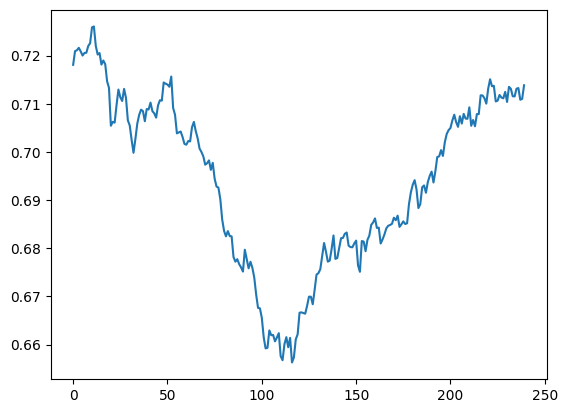

In [ ]:
plt.plot(np.correlate(finite_dscs, np.ones(100)/100))

In [ ]:
display(pd.DataFrame(test_results).mean())

hard_dsc    0.679150
soft_dsc    0.658842
cent        0.043066
dtype: float64

In [46]:
display(pd.DataFrame(test_results).mean())

hard_dsc    0.683518
soft_dsc    0.663130
cent        0.038930
dtype: float64

In [35]:
1

In [36]:
1

hard_dsc    0.695916
soft_dsc    0.696083
cent        0.030052
dtype: float64

0.7422285987565758

array([0.7661771, 0.6034883], dtype=float32)